## 5. Classification 네트워크 구성

- Input Layer → Hidden Layers (활성화 함수 사용) → Output Layer
- 이진 분류(binary classification):
    - 출력 차원: `(B, 1)`
    - 출력에 **Sigmoid 함수** 사용
    - 예측 확률이 0.5 이상이면 1, 미만이면 0
    - Binary Cross Entropy Loss 사용:
        
        $$
        \text{Loss} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
        $$

In [2]:
import pandas as pd

df = pd.read_csv('data/classify5k.csv')

data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

print(f'data: {data}, labels: {labels}')


data: [[ 0.09762701  0.43037873]
 [ 0.20552675  0.08976637]
 [-0.1526904   0.29178823]
 ...
 [ 0.47100447  0.10089364]
 [-0.20569733  0.51685904]
 [-0.95242515  0.62715016]], labels: (5000, 1)


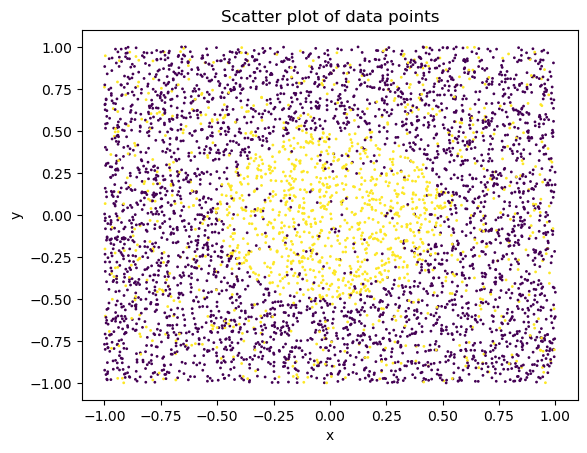

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=1)
plt.title('Scatter plot of data points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [15]:
import torch
data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.float32)

# 학습데이터를 7:3 정도로 train/validation으로 나누기
data_length = len(data_torch)
split_n = int(data_length * 0.7)
train_data = data_torch[:split_n]
train_labels = labels_torch[:split_n]
val_data = data_torch[split_n:]
val_labels = labels_torch[split_n:]


In [10]:
g = torch.Generator().manual_seed(42)

# 배치로 데이터를 묶음(mini-batch)
def get_batch(x, y, batch_size):
  data_length = len(x)
  indices = torch.randint(0, data_length, (batch_size,), generator=g)

  x_batch = x[indices]
  y_batch = y[indices]
  return x_batch, y_batch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    # nn.Sequential을 사용하여 여러 레이어를 연결
    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, output_size),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  


net = Net(2, 4, 1)

# nn.BCEWithLogitsLoss는 sigmoid와 binary cross entropy를 합친 것
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  loss = loss_fn(output, label_batch)

  loss.backward()
  optimizer.step()

  optimizer.zero_grad()

  if steps % 1000 == 0:
    net.eval()
    output = net(val_data)
    val_loss = loss_fn(output, val_labels)
    print(f"{steps} val_loss: {val_loss.item()}")


0 val_loss: 0.925592303276062
1000 val_loss: 0.5971211791038513
2000 val_loss: 0.596116304397583
3000 val_loss: 0.5952931046485901
4000 val_loss: 0.5944840908050537
5000 val_loss: 0.5935282707214355
6000 val_loss: 0.5923261046409607
7000 val_loss: 0.5907231569290161
8000 val_loss: 0.5888584852218628
9000 val_loss: 0.5860033631324768
10000 val_loss: 0.5822105407714844
11000 val_loss: 0.577768862247467
12000 val_loss: 0.5728196501731873
13000 val_loss: 0.5676422715187073
14000 val_loss: 0.5625930428504944
15000 val_loss: 0.5564497709274292
16000 val_loss: 0.5469458103179932
17000 val_loss: 0.5364423394203186
18000 val_loss: 0.5273231863975525
19000 val_loss: 0.5189042687416077
20000 val_loss: 0.5122588872909546
21000 val_loss: 0.5058154463768005
22000 val_loss: 0.5014842748641968
23000 val_loss: 0.49726834893226624
24000 val_loss: 0.494416743516922
25000 val_loss: 0.49207040667533875
26000 val_loss: 0.4902819097042084
27000 val_loss: 0.4889179766178131
28000 val_loss: 0.4874995946884155


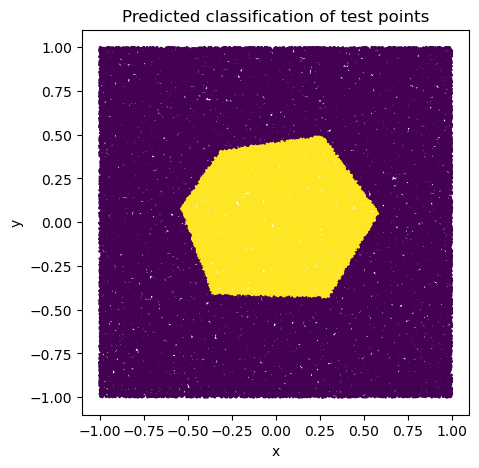

In [39]:
import numpy as np
import matplotlib.pyplot as plt

n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
points_test_torch = torch.from_numpy(points_test).float()

net.eval()
output_test = net(points_test_torch)
probability = torch.sigmoid(output_test)
prediction = (probability > 0.5).float()

prediction_np = prediction.numpy()

plt.figure(figsize=(5, 5))
plt.scatter(points_test[:, 0], points_test[:, 1], c=prediction_np, cmap='viridis', s=1)
plt.title('Predicted classification of test points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
